In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1 task ----------------------------------------------------------------------------------------------------------------------------------

In [428]:
reg_df = pd.read_csv('/Users/dyadyundanil/Desktop/UNZIP_ME_FOR_NOTEBOOKS_ML_RUS_V11/My_Working/Final_project/problem1-reg_data.csv',
                     delimiter=';')
auth_df = pd.read_csv('/Users/dyadyundanil/Desktop/UNZIP_ME_FOR_NOTEBOOKS_ML_RUS_V11/My_Working/Final_project/problem1-auth_data.csv',
                     delimiter=';')

In [438]:
# Convert to date (registration df)
reg_df['reg_ts'] = reg_df['reg_ts'].astype(int)
reg_df['reg_ts'] = pd.to_datetime(reg_df['reg_ts'], unit='s')

# Convert to date (auth df)
auth_df['auth_ts'] = auth_df['auth_ts'].astype(int)
auth_df['auth_ts'] = pd.to_datetime(auth_df['auth_ts'], unit='s')

In [440]:
merge_df = reg_df.iloc[:,[0,1]].merge(auth_df.iloc[:,[0,1]], on='uid', how='inner')
merge_df['reg_ts'] = pd.to_datetime(merge_df['reg_ts'].dt.date)
merge_df['auth_ts'] = pd.to_datetime(merge_df['auth_ts'].dt.date)
merge_df.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [442]:
# На вход функция принимает 3 параметра: 
# merge_df - подготовленный датафрейм с данными о регистрации, аутентификации и собственного id
# date_start - дата, с которой начинается отсчет первой когорты
# date_end - последняя когорта
def retention_rate(merge_df, date_start, date_end):

    #выбор нужного периода в исходном датасете
    sample = merge_df[(merge_df['reg_ts'] >= date_start) & (merge_df['auth_ts'] <= date_end)].copy()
    sample['return_day'] = (sample['auth_ts'] - sample['reg_ts']).dt.days
    sample['reg_ts'] = sample['reg_ts'].astype(str)

    #Расчет retention table
    retention_pred = sample.groupby(['reg_ts', 'return_day']).agg(cnt=('uid','nunique')).reset_index()
    retention_pivot = retention_pred.pivot(index='reg_ts', columns='return_day', values='cnt').fillna(0)
    retention_pivot = np.round(retention_pivot.div(retention_pivot[0], axis=0), 3)

    #Отрисовка heatmap for retention 
    plt.figure(figsize=(15,10)) #'BuPu_r', 'RdYlGn'
    sns.heatmap(data=retention_pivot, annot=True, fmt = '.1%', cmap="RdYlGn", vmin = 0.0, vmax = 0.1, annot_kws={"size": 6})
    plt.ylabel('Cohort day')
    plt.title('Cohort Retention rates')
    plt.yticks(rotation=1); 

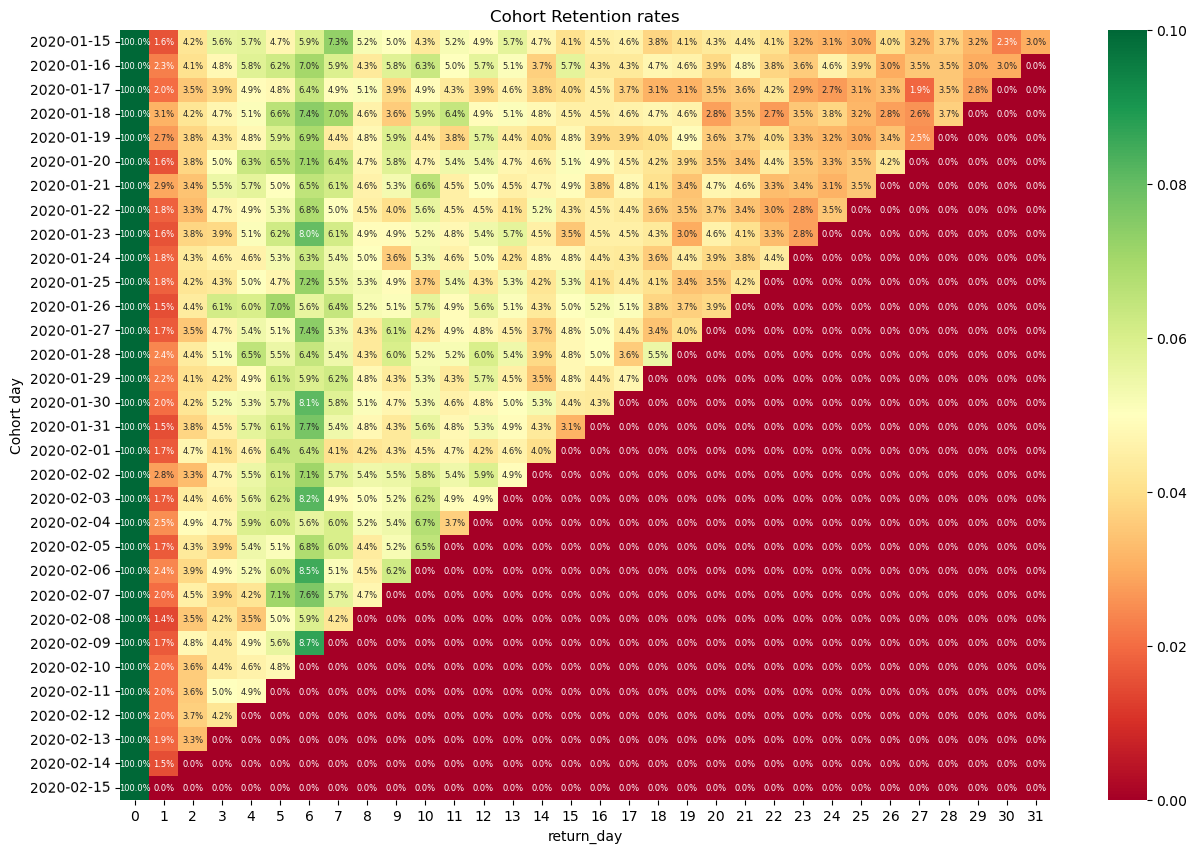

In [444]:
start = '2020-01-15'
end = '2020-02-15'
retention_rate(merge_df, start, end)

In [ ]:
# 2 task ----------------------------------------------------------------------------------------------------------------------------------

In [5]:
df = pd.read_csv('/Users/dyadyundanil/Desktop/UNZIP_ME_FOR_NOTEBOOKS_ML_RUS_V11/My_Working/Final_project/AB_test.csv', delimiter=';')

In [7]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [290]:
# Количесвто платящих пользователей и общее число пользователей в группах
pay_users = df[df['revenue']>0].groupby('testgroup').agg(cnt=('user_id','nunique'))
all_users = df.groupby('testgroup').agg(cnt=('user_id','nunique'))
pay_users.merge(all_users, on='testgroup').rename(columns={'cnt_x':'paying_users', 'cnt_y':'all_users'})

,paying_users,all_users
testgroup,,
a,1928,202103
b,1805,202667


In [420]:
# Сразу видим что дисперсия данных сильно различна (повод в дальнейшем делать поправку на различие в дисперсиях)
revenue_a = df[df['testgroup'] == 'a']
revenue_b = df[df['testgroup'] == 'b']
revenue_a['revenue'].describe(), revenue_b['revenue'].describe(), revenue_a['revenue'].sum(), revenue_b['revenue'].sum()

(count    202103.000000
 mean         25.413720
 std         920.768137
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max       37433.000000
 Name: revenue, dtype: float64,
 count    202667.000000
 mean         26.751287
 std         287.324162
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max        4000.000000
 Name: revenue, dtype: float64,
 5136189,
 5421603)

In [ ]:
# Итак, изначально определимся какие метрики наиболее значимы для принятия решения
# 1) ARPU - средняя выручка с пользователя
# 2) ARPPU - средняя выручка с платящего пользователя
# 3) Conversion to paying - конверсия пользователей из неплятящего в платящего
# Но перед этим мы посмотрим на распределние нашего целевого признака (revenue) в обеих группах

Всего пользователей в контрольной группе: 202103
Всего неплатящих пользователей в контрольной группе: 200175
Всего платящих (небольшую сумму - от 200 до 400) пользователей в контрольной группе: 1805
Всего платящих (большую сумму - больше 37000) пользователей в контрольной группе: 123 , процент от всех плятящих: 6.38


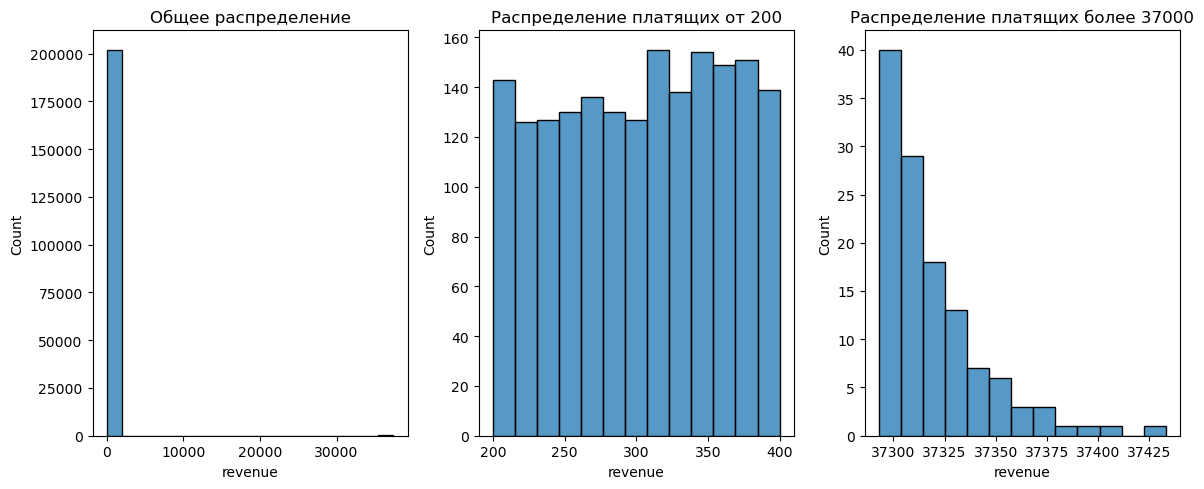

In [380]:
#Контрольная группа
revenue_a = df[df['testgroup'] == 'a']

print('Всего пользователей в контрольной группе:', len(revenue_a))
print('Всего неплатящих пользователей в контрольной группе:', len(revenue_a.query('revenue == 0')))

print('Всего платящих (небольшую сумму - от 200 до 400) пользователей в контрольной группе:', 
      len(revenue_a.query('revenue < 500 & revenue > 0')))

print('Всего платящих (большую сумму - больше 37000) пользователей в контрольной группе:', 
      len(revenue_a.query('revenue > 500')), 
      ', процент от всех плятящих:', round(len(revenue_a.query('revenue > 500'))/ len(revenue_a.query('revenue != 0')) * 100, 2))

# sns.displot(revenue_a.query('revenue < 500 & revenue > 0')['revenue'])
# sns.displot(revenue_a.query('revenue > 500')['revenue'])

fig, axs = plt.subplots(1, 3, figsize=(12, 5))  # 1 строка, 2 столбца

sns.histplot(revenue_a['revenue'], ax=axs[0])
axs[0].set_title('Общее распределение')
sns.histplot(revenue_a.query('revenue < 500 & revenue > 0')['revenue'], ax=axs[1])
axs[1].set_title('Распределение платящих от 200')
sns.histplot(revenue_a.query('revenue > 500')['revenue'], ax=axs[2])
axs[2].set_title('Распределение платящих более 37000')
plt.tight_layout()

Всего пользователей в тестовой группе: 202667
Всего неплатящих пользователей в тестовой группе: 200862
Всего платящих (небольшую сумму - от 2000 до 4000) пользователей в тестовой группе: 1805


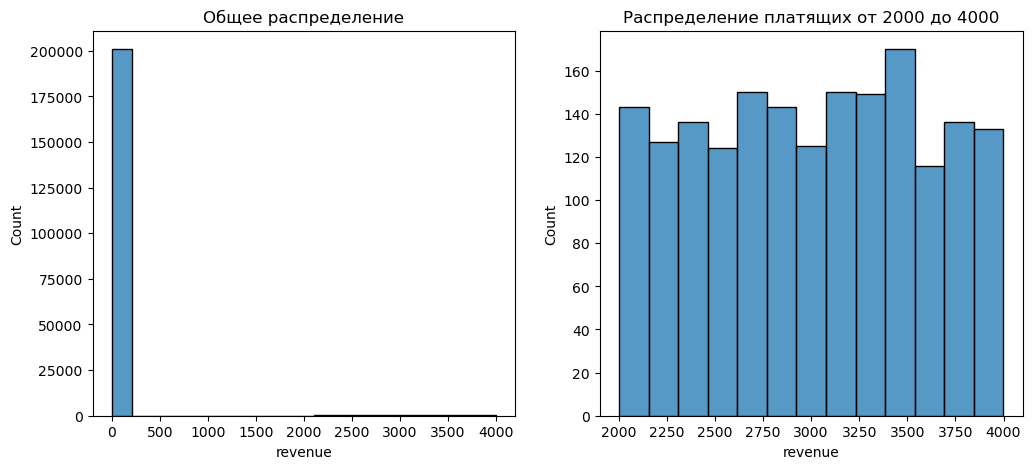

In [346]:
# Тестовая группа
revenue_b = df[df['testgroup'] == 'b']

print('Всего пользователей в тестовой группе:', len(revenue_b))
print('Всего неплатящих пользователей в тестовой группе:', len(revenue_b.query('revenue == 0')))

print('Всего платящих (небольшую сумму - от 2000 до 4000) пользователей в тестовой группе:', 
      len(revenue_b.query('revenue >= 2000 & revenue <= 4000')))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 строка, 2 столбца

sns.histplot(revenue_b['revenue'], ax=axs[0])
axs[0].set_title('Общее распределение')
sns.histplot(revenue_b.query('revenue > 2000 & revenue < 4000')['revenue'], ax=axs[1])
axs[1].set_title('Распределение платящих от 2000 до 4000');

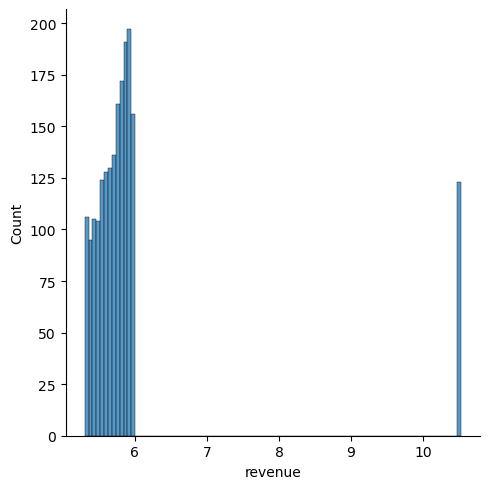

In [386]:
# Как видно логарифмирование данных не помогает в данном случае избавиться от ненормальности
sns.displot(np.log1p(df.query('testgroup == "a" & revenue > 0')['revenue']))

In [ ]:
# 1) Итак, во-первых, во боих группах данные распределены не нормально (судя по гистограммам и ввиду того, 
# что это заметно невооруженным глазом,
# мы не будем проверять на нормальность другими способами (проверкой критериев или с помощью того же qq-plot))

# 2) Во-вторых, мы видим, что в контрольной группе содержатся экстремально большие значение (outliers) - пользователи, 
# приносящие больше 37000. 
# Таких пользователй примерно 6% от всех платящих и так как они для являются ценным источником ифнормации - от низ избавляться не будем

# 3) В-третьих, заметно, что в тестовой группе таких больших значений не существует, но ровно 1805 пользователй стали приносить выручку в 
# диапазоне (2000, 4000), что явялется учетверенным интервалом контсрольной группы (200, 400)
# То есть часть пользователей стало приносить большую выручку, а часть полностью перестала что-либо покупать

# 4) Также заметим, что логарифмирование данных не приводит к нормальному распредлению (представлено выше)

# Все вышесказанное никак не отразится на тесте хи-вквадрат для проверки о значимости в различии конверсии, 
# но из-за не нормальность данных нам нужно аккуратно обойтись с тестом для средних метрик ARPU и ARPPU.
# B этом случае ввиду большего набора данных (>100_000) и полагаясь на центральную предельную теорему, 
# мы будем использовать t-test с поправкой на неравенство дисперсии (тест Уэлча)

# Все следующие тесты мы провеяем на уровне значимости 0.05 (5%)

In [388]:
from scipy.stats import ttest_ind

In [400]:
# ARPU (average revenue per user) = total_revenue / users
ARPU_a = df.query('testgroup == "a"')['revenue'].sum() / len(df.query('testgroup == "a"'))
ARPU_b = df.query('testgroup == "b"')['revenue'].sum() / len(df.query('testgroup == "b"'))

print('ARPU in control group:', round(ARPU_a,2))
print('ARPU in test group:', round(ARPU_b,2))
print("T-test (Welch) p-value", 
      round(ttest_ind(df.query('testgroup == "a"')['revenue'], 
                df.query('testgroup == "b"')['revenue'], 
                alternative='less', 
                equal_var=False).pvalue, 2))


ARPU in control group: 25.41
ARPU in test group: 26.75
T-test (Welch) p-value 0.27


In [ ]:
# Итак, p-value > 0.05 -> мы не можем отвергнуть нулевую гипотезу о равенстве средних ARPU в группах. (результат не значим)
# Простым языком, акции никак не повлияли на ARPU

In [414]:
# ARPPU (average revenue per paying user) = total_revenue / paying_users
ARPPU_a = df.query('revenue > 0 & testgroup == "a"')['revenue'].sum() / len(df.query('revenue > 0 & testgroup == "a"'))
ARPPU_b = df.query('revenue > 0 & testgroup == "b"')['revenue'].sum() / len(df.query('revenue > 0 & testgroup == "b"'))

print('ARPPU in control group:', round(ARPPU_a))
print('ARPPU in test group:', round(ARPPU_b))
print('T-test (Welch) p-value', round(ttest_ind(df.query('revenue > 0 & testgroup == "a"')['revenue'], 
                df.query('revenue > 0 & testgroup == "b"')['revenue'], 
                alternative='less', 
                equal_var=False).pvalue, 4))

ARPPU in control group: 2664
ARPPU in test group: 3004
T-test (Welch) p-value 0.0501


In [ ]:
# Что ж, наше p-value = 0.05, и тут нужно быть аккуратным, тк технически мы можем не отвергать нулевую гипотезу и 
# как результат различие в метрике ARPPU будут не значимы. 
# Мы решаем сделать следующим образом:
# - провести тест на различие в convertion rate
# - если так получится, что CR упадет во второй группе, то данную гипотезу мы не отвергнем
# - иначе нулевую гипотезу отвергнем и примем наши рещультаты как ститистически значимыми

In [418]:
# Conversion to paying users = paying_users / users
# We will use Chi-Square test
from scipy.stats import chi2_contingency
contingency_table = [
    [pay_users.loc['a','cnt'], all_users.loc['a','cnt']],
    [pay_users.loc['b','cnt'], all_users.loc['b','cnt']]
]

print('p-value of Chi-Square test', round(chi2_contingency(contingency_table).pvalue, 3))
# CR significantly differs between groups

CR_a = len(df.query('revenue > 0 & testgroup == "a"')) / len(df.query('testgroup == "a"')) * 100
CR_b = len(df.query('revenue > 0 & testgroup == "b"')) / len(df.query('testgroup == "b"')) * 100
print('Conversion rate of a_group: ', round(CR_a, 2), '%', sep='')
print('Conversion rate of b_group: ', round(CR_b,2), '%', sep='')

p-value of Chi-Square test 0.038
Conversion rate of a_group: 0.95%
Conversion rate of b_group: 0.89%


In [422]:
# В итоге, Chi-Square test показал, что наши результаты значимые - величина CR в обоих группах действительно различается
# То есть спад на 0.06% оказался действительным
# И как упомяналось в предудыщем пункте мы отвергаем не отвергаем гипотезу о равенстве ARPPU

In [424]:
# Окончательный ответ:
# Прирост в таких метриках как ARPU и ARPPU оказался не значимым
# В то время как значение конверсии в оплату упало - наша задача увеличивать данную метрику
# Из всего этого мы делаем вывод, что новые акционные предложения не стоит выводить на всю аудиторию

In [ ]:
# 3 task ----------------------------------------------------------------------------------------------------------------------------------

In [426]:
# Ответ на вопрос: С помощью каких метрик можно оценить результаты последнего прошедшего события?
# 1) Например метрика, показывающая долю пользователей которая приступила к испытанию (конверсия в испытание)
# 2) Далее, например, конверсия в уровни (то есть построить некую воронку прохождения испытания), таким образом отслеживать поведение 
#    игрока при прохождении уровней
# 3) Среднее время прохождения испытания (наша цель увеличивать это значение до определнного порога - когда игра не нстолько простая,
#    чтобы завлекать игрока и не столько сложная, чтобы отбивать все желание играть в игру)
# 4) Можем следить за метрикой DAU (вдруг введение нового испытания никак не повлияло на вовлеченность пользователей)
# 5) Длительность игровой сессии (Session lenght) - задача стоит в увеличении той метрики
# 6) Например похожую на предыдущею Session interval (как часто игрок заходит в игру) - если с введением события стал чаще заходить, то
#    вовлеченность игрока растет

In [ ]:
# Ответ на вопрос: Предположим, в другом событии мы усложнили механику событий так, 
# что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 
# Изменится ли набор метрик оценки результата? Если да, то как?
# - Да, изменится. Предыдущие остаются, но можно добавить еще несколько.
# 1) Среднее кол-во неудачных попыток (если это значени слишком большое, то следует упростить испытание)
# 2) Доля игроков дошедших до конца (в сравнении со всеми, кто хоть раз играл в испытание)
# 3) Число попыток на котором игром останавливался проходить испытание (если значение низкое, значит у игрока мыло мотивации проходить его)